# **Detección de fraude en Tarjetas de Crédito mediante Codificadores Automáticos**

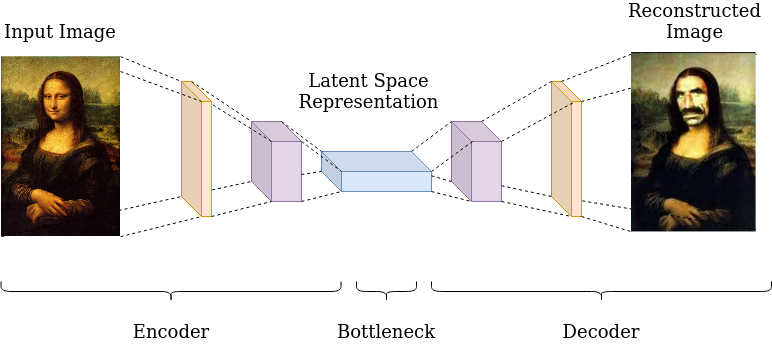

In [ ]:
#@title Autoencoder

from IPython.display import Image
Image("/content/drive/MyDrive/autoencoder.png")

Un **Autoencoder** es una red neuronal no supervisada que intenta reconstruir los datos de entrada en la capa de salida.








            



Un **autocodificador generalmente consta de tres partes**: 


La parte del codificador, la capa de codificación y el descodificador.



El Autoencoder acepta datos de entrada de alta dimensión, los comprime hasta la representación del espacio latente en la capa oculta del cuello de botella; el decodificador toma la representación latente de los datos como entrada para reconstruir los datos de entrada originales.




**Detección de anomalías mediante codificadores automáticos:**


Siga los siguientes pasos para detectar anomalías en un conjunto de datos de gran dimensión. También puede aplicar esto a conjuntos de datos no balanceados.
Durante el entrenamiento, ingrese solo transacciones normales en el codificador. La capa de cuello de botella aprenderá la representación latente de los datos de entrada normales.
El decodificador utilizará la salida de las capas de cuello de botella para reconstruir las transacciones normales de los datos de entrada originales.
Una transacción fraudulenta será diferente a una transacción normal. El Autoencoder tendrá problemas para reconstruir la transacción fraudulenta y, por lo tanto, el error de reconstrucción será alto.
Puede marcar una nueva transacción como fraudulenta en función de un valor de umbral especificado para el error de reconstrucción.


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Cargando el data set

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")
df.head(n=5) # 5 primeras filas del data set

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print('Check number of Rows and Columns') # nemero de filas y columnas del data set
print(df.shape)

print('Check if any Missing values')
df.isnull().values.any() # validando si hay missing en el data set

Check number of Rows and Columns
(284807, 31)
Check if any Missing values


False

In [ ]:
print ('Number of Fraud Transctions') # Número de transacciones fraudulentas
frauds = df[df.Class == 1] # Etiqueta de transacción fraudulenta es 1
print(frauds.shape) # Cantidad de registros de dataframe fraud

print ('Number of Normal Transctions')  # Número de transacciones normales
normal = df[df.Class == 0]  # Etiqueta de transacción normal es 1
print(normal.shape)  # Cantidad de registros de dataframe normal

Number of Fraud Transctions
(492, 31)
Number of Normal Transctions
(284315, 31)


Se Normaliza la característica “amount” (el monto de las transacciones), para que tenga valor medio igual a cero y desviación estándar igual a 1 (comparables con las características V1 a V28). 

In [ ]:
#Escalando los datos
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1) #Eliminamos la variable Time
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1)) # Escalamos la variable Amount

Luego. se crea el set de entrenamiento (que corresponde al 80% de los registros) y el de validación (que tendrá el 20% restante). Esto se logra fácilmente con la función train_test_split de la librería Scikit-Learn.




 **El autoencoder será entrenado únicamente con registros “normales”**, para que de esta forma aprenda a obtener una representación compacta de esos datos “normales”. Una vez entrenado, y cuando se introduzca un registro “fraudulento”, se esperaría que la reconstrucción del dato no sea tan precisa y por tanto la diferencia (o error) entre el dato reconstruido y el original será más grande que aquella obtenida cuando el dato ingresado es normal.



 

Así que el set de entrenamiento contendrá únicamente registros normales, mientras que el de validación tendrá los dos tipos de registros (normales y fraudulentos):

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

In [ ]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(227451, 29)

# **Construcción del modelo**

El  Autoencoder utiliza 4 capas completamente conectadas con 14, 7, 7 y 29 neuronas respectivamente. Las dos primeras capas se utilizan para nuestro codificador, las dos últimas van para el decodificador. Además, la regularización L1 se utilizará durante el entrenamiento:

In [ ]:

input_dim = X_train.shape[1]

encoding_dim = 14
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)


decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)


autoencoder = Model(inputs=input_layer, outputs=decoder)

Se entrena el  modelo para 100 épocas con un tamaño de lote de 32 muestras y se guarda el modelo de mejor rendimiento en un archivo. El ModelCheckpoint proporcionado por Keras es realmente útil para tales tareas. Además, el progreso del entrenamiento se exportará en un formato que comprenda TensorBoard.

In [ ]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])


checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)


tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)




El entrenamiento se hará únicamente con las transacciones normales (set X_train)




Se entrenará el modelo usando un total de 100 iteraciones, y usando tamaños de lote de 32 (es decir, presentaremos al modelo bloques de 32 ejemplos durante el entrenamiento).




Es importante observar que para este entrenamiento se define X_train como el dato tanto de entrada como de salida del modelo:




In [ ]:
#Entrenando el modelo con fit
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 37s 3ms/step - loss: 0.8517 - accuracy: 0.5264 - val_loss: 0.7790 - val_accuracy: 0.6782
Epoch 2/100
7108/7108 [==============================] - 22s 3ms/step - loss: 0.7525 - accuracy: 0.6877 - val_loss: 0.7555 - val_accuracy: 0.7021
Epoch 3/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7130 - accuracy: 0.7056 - val_loss: 0.7499 - val_accuracy: 0.7000
Epoch 4/100
7108/7108 [==============================] - 21s 3ms/step - loss: 0.7234 - accuracy: 0.7098 - val_loss: 0.7458 - val_accuracy: 0.7126
Epoch 5/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7119 - accuracy: 0.7149 - val_loss: 0.7419 - val_accuracy: 0.7203
Epoch 6/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7106 - accuracy: 0.7139 - val_loss: 0.7456 - val_accuracy: 0.7170
Epoch 7/100
7108/7108 [==============================] - 19s 3ms/step - loss: 0.7083 - accuracy: 0.7181 - val_loss: 0.7373 -

In [ ]:
autoencoder = load_model('model.h5')

# **Evaluación del rendimiento  del modelo**

El error de reconstrucción de los datos de entrenamiento y prueba parece converger muy bien, pues tienden a ser bajos. 

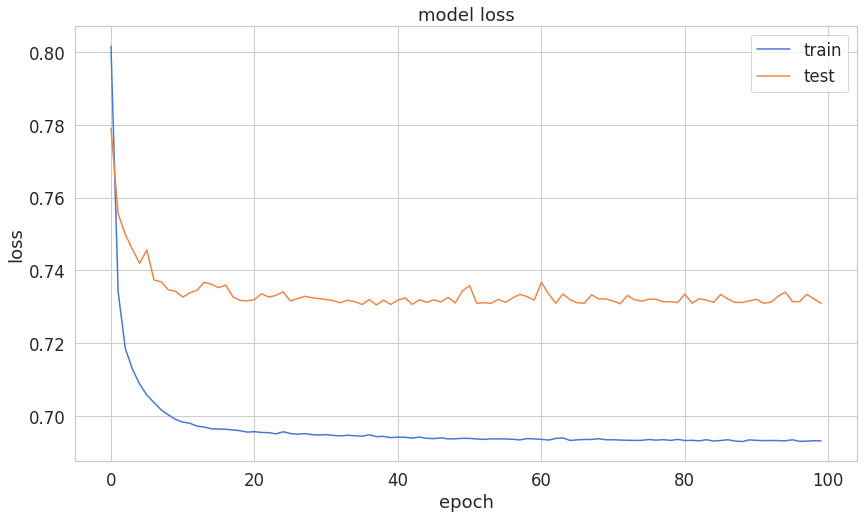

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.729485,0.001720
std,3.464807,0.041443
min,0.037367,0.000000
25%,0.230914,0.000000
50%,0.383268,0.000000
75%,0.610657,0.000000
max,260.381061,1.000000


# **Curva ROC**

In [ ]:

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

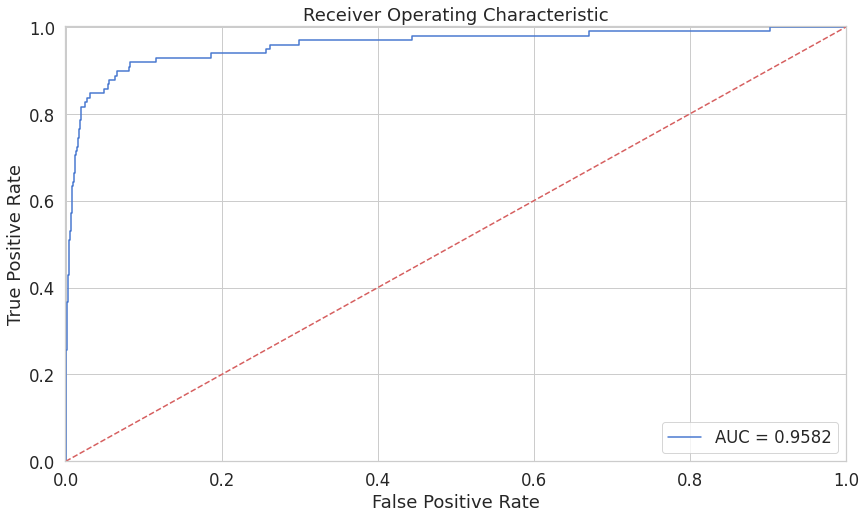

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

La curva ROC traza la tasa de verdaderos positivos frente a la tasa de falsos positivos, sobre diferentes valores de umbral. Básicamente, se busca que la línea azul esté lo más cerca posible de la esquina superior izquierda.Se observa que el valor de AUC es de 0,96, valor bastante alto, y bueno

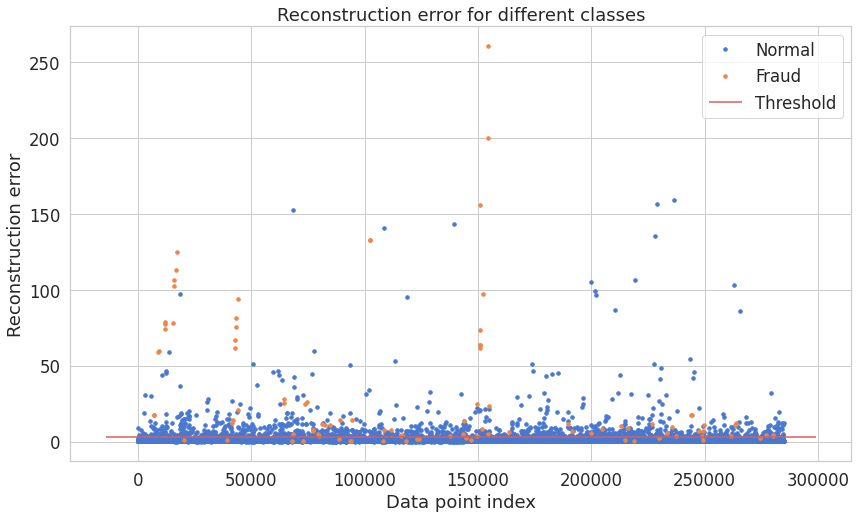

In [ ]:
threshold = 2.9

## And see how well we’re dividing the two types of transactions:

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Detecte fraudes en tarjetas de crédito (anomalías) como puntos donde la pérdida de reconstrucción es mayor que un umbral fijo. Para estos datos se hallo que que un valor 2.9  para el umbral será bueno.

De esta manera si el error de reconstrucción de la transacción es mayor a 2.9 entonces la transacción sera clasificada como fraudulenta.

# **Matriz de confusión**

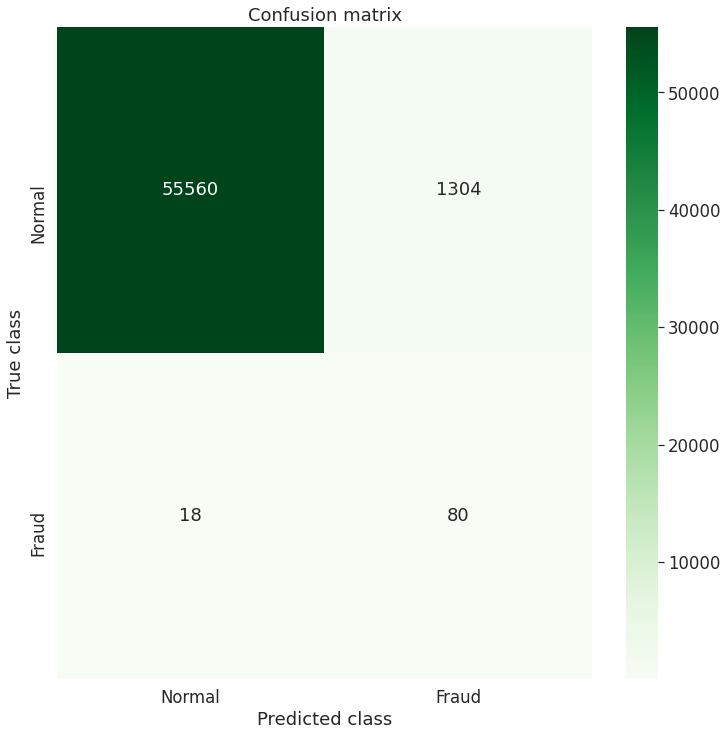

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, cmap=plt.cm.Greens, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

El  codificador automático ha aprendido a discriminar  anomalías.Se ha clasificado correctamente a 79  de los 98 casos fradulentos,  lo que representa el 81% del total de los casos. Sin embargo, al mismo tiempo, se ha  clasificado erróneamente 1254 casos como fradulentos (son normales), esto representa el 2,2 % de los casos normales, lo que podria provocar insatisfacción en el cliente. 

**Referencias:**


Anomaly Detection using Unsupervised Methods:Credit Card Fraud Case Study
https://thesai.org/Downloads/Volume10No11Paper_1-Anomaly_Detection_using_Unsupervised_Methods.pdf

A Comparison Study of Credit Card Fraud Detection: Supervised versus Unsupervised.https://arxiv.org/abs/1904.10604


An Autoencoder Based Model for Detecting Fraudulent Credit Card Transaction.
https://www.sciencedirect.com/science/article/pii/S1877050920306840

Thesis Autoencoding Credit Card Fraud.
https://www.cs.ru.nl/bachelors-theses/2018Tom_Sweers___4584325___Autoencoding_credit_card_fraude.pdf




Building Autoencoders in Keras. https://blog.keras.iobuilding-autoencoders-in-keras.html




Stanford tutorial on Autoencoders. http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/


Introducción a los codificadores automáticos. https://www.tensorflow.org/tutorials/generative/autoencoder#third_example_anomaly_detection

Nota:

stos link no deben it en github, estos gfue los que use para desarrolar este notebbok
ecpoia de este:
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd


Y tambien me apoye en 
https://towardsdatascience.com/anomaly-detection-using-autoencoders-5b032178a1ea


tengo una lista de link en word que tengo en escrittorio mis documentos y voya subir a la nube de belxis